In [1]:
from birdset.datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper
from transformers import Wav2Vec2Model, HubertModel, Trainer
import torch
from torchmetrics import Accuracy, Precision
import time
import fairseq
from tqdm import tqdm
import lightning as lt
from huggingface_hub import PyTorchModelHubMixin
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.classification.average_precision import AveragePrecision
from torchmetrics.classification.auroc import AUROC
from sklearn.metrics import average_precision_score
import time, os
from sklearn.manifold import TSNE

In [2]:
model_name_base = "facebook/hubert-base-ls960"
model_name_large = "facebook/hubert-large-ll60k"
model_name_xlarge = "facebook/hubert-xlarge-ll60k"
model_name = model_name_base
basemodel = Wav2Vec2Model.from_pretrained(model_name, torch_dtype=torch.float16, attn_implementation=None)
model = basemodel.feature_extractor
model = model.to("cuda:1")
model.requires_grad_(False)
model.eval()

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)

In [3]:
from Model import Modelwrapper

#model = Modelwrapper.load_model("D:\\Documents\\Uni\DLL\\Code\models\\Modelwrapper06-10-2024-21-00-09_large50.pt", basemodel)

In [4]:
transforms = BirdSetTransformsWrapper(
        task="multiclass",
        sampling_rate = 16000,
        model_type = 'waveform',
    )

dataset_name = "HSN"
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir='B:\DLL\Datasets',
        dataset_name= "",
        hf_path='DBD-research-group/BirdSet',
        hf_name=dataset_name,
        n_workers=8,
        val_split=0.2,
        task="multiclass",
        classlimit=500,
        eventlimit=1,
        sampling_rate=16000,
    ),
    transforms=transforms
)

dm.prepare_data()
dm.setup(stage="fit")
dm.setup(stage="test")
train_dataloader = dm.train_dataloader()
test_dataloader = dm.test_dataloader()
print(type(test_dataloader.dataset))
print(test_dataloader.dataset)
print(type(test_dataloader))

Saving the dataset (0/1 shards):   0%|          | 0/8978 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2245 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10296 [00:00<?, ? examples/s]

<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
    num_rows: 10296
})
<class 'torch.utils.data.dataloader.DataLoader'>


In [5]:
features = []
labels = []
model.eval()
for batch in train_dataloader:
    features.append(model(batch["input_values"].squeeze().half().to("cuda:1")))
    labels.append(batch["labels"])
print(len(features))
print(features[0].shape)

281
torch.Size([32, 512, 249])


In [6]:
print(features[0].shape)
labels_cat = torch.cat(labels).to("cpu")
print(labels_cat.shape)
concated = torch.cat(features).to("cpu")
print(concated.shape)

torch.Size([32, 512, 249])
torch.Size([8978])
torch.Size([8978, 512, 249])


In [7]:
flattened = concated.flatten(start_dim=1)
print(flattened.shape)

torch.Size([8978, 127488])


In [8]:

import matplotlib.pyplot as plt
tsne = TSNE()
small_features = tsne.fit_transform(flattened)

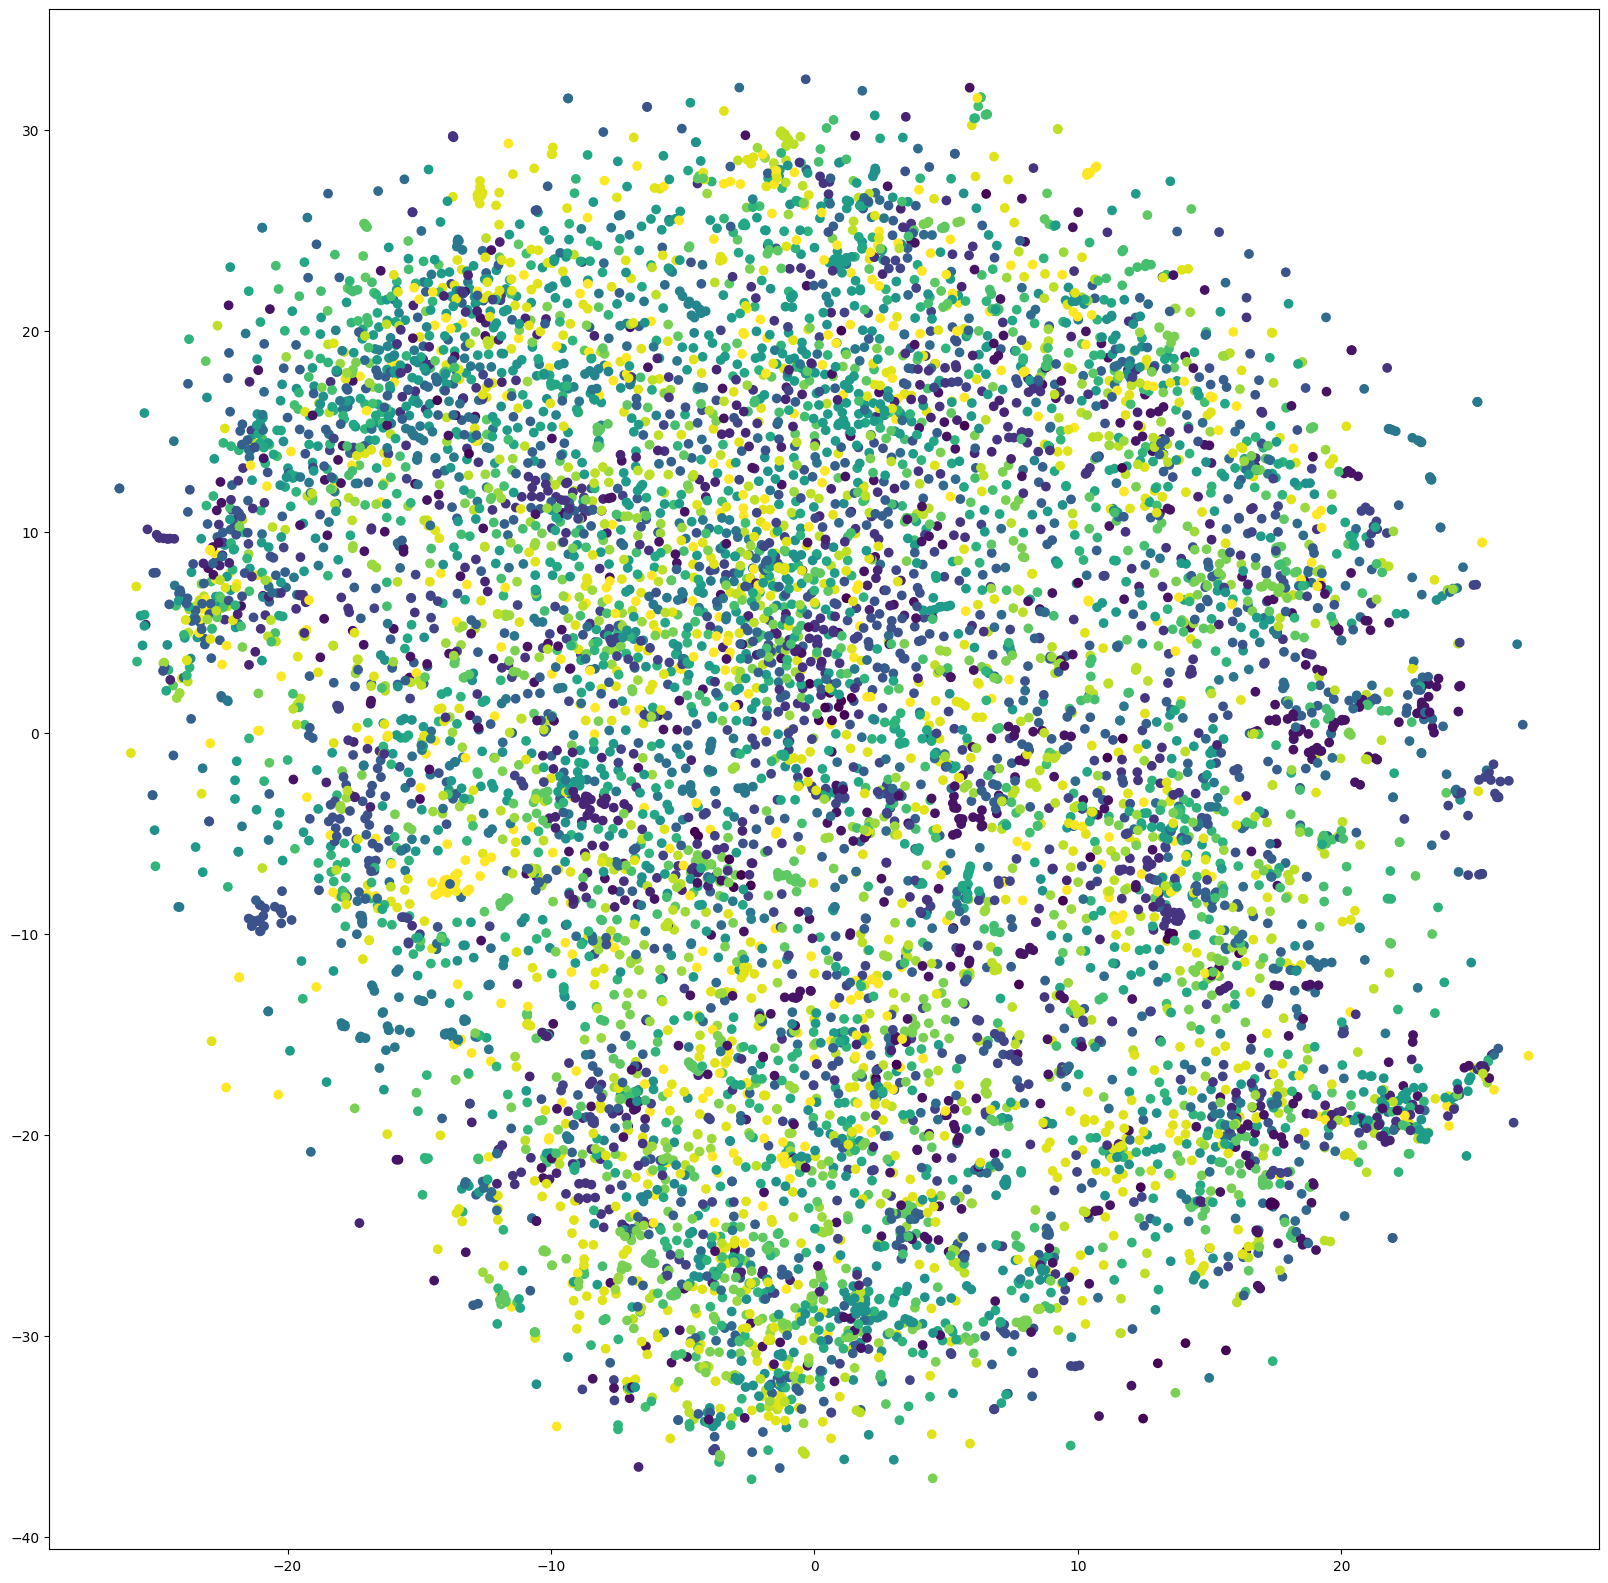

In [16]:
plt.figure(figsize=(20,20))
plt.scatter(small_features[:,0], small_features[:,1], c=labels_cat)

In [10]:
import soundfile as sf
import numpy as np
pathi = "B:\DLL\Datasets\LibriSpeech_wav"
features_speech = []
#min_len, max_len = -1,-1
for filename in os.listdir(pathi):
    if(filename.endswith(".wav")):
        complete = os.path.join(pathi, filename)
        data, samplerate = sf.read(complete)
        #if(max_len == -1 or len(data) > max_len):
        #    max_len = len(data)
        #if(min_len == -1 or len(data) < min_len):
        #    min_len = len(data)
        features_speech.append(model(torch.Tensor(data[:20560]).reshape(1,-1).half().to("cuda:1")).flatten().to("cpu"))
#print(min_len, max_len)# 20560 559280
print(len(features_speech))
print(features_speech[0].shape)

28539
torch.Size([32768])


In [11]:
b = torch.cat(features_speech).reshape(len(features_speech), features_speech[0].shape[0])
print(b.shape)

torch.Size([28539, 32768])


In [12]:
import matplotlib.pyplot as plt
tsne = TSNE()
small_features_speech = tsne.fit_transform(b)

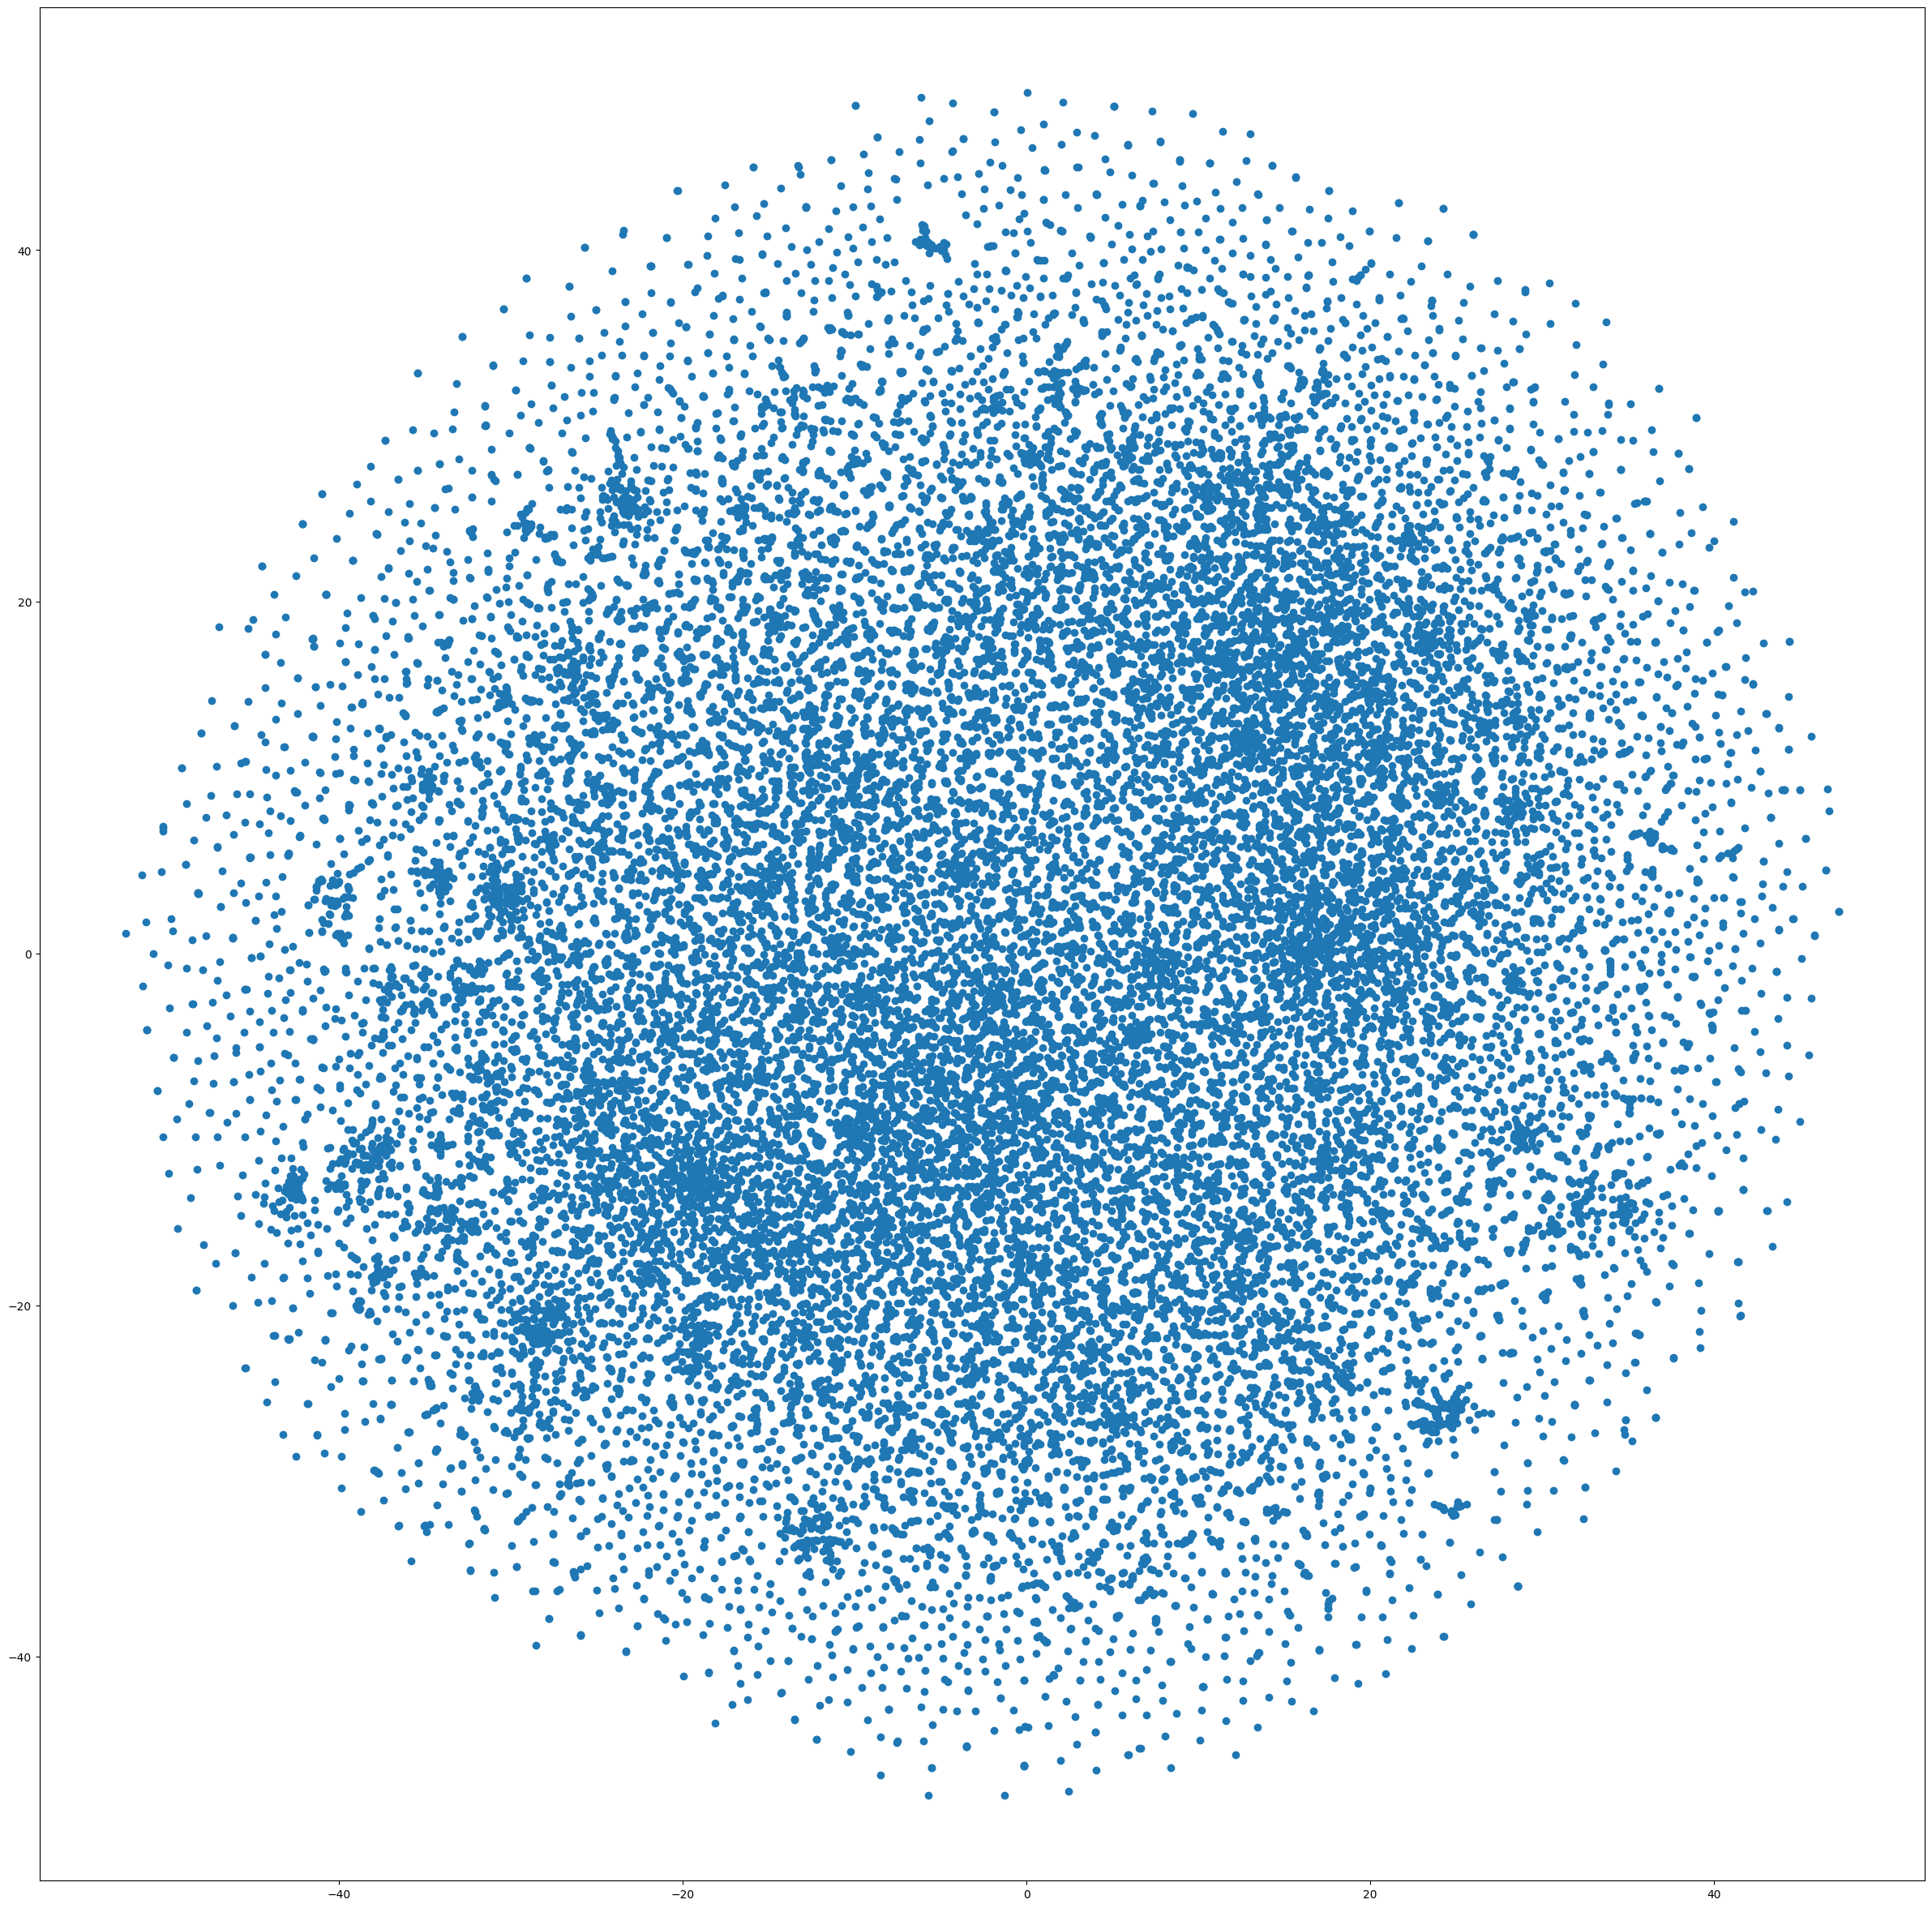

In [13]:

plt.figure(figsize=(30,30))
plt.scatter(small_features_speech[:,0], small_features_speech[:,1])

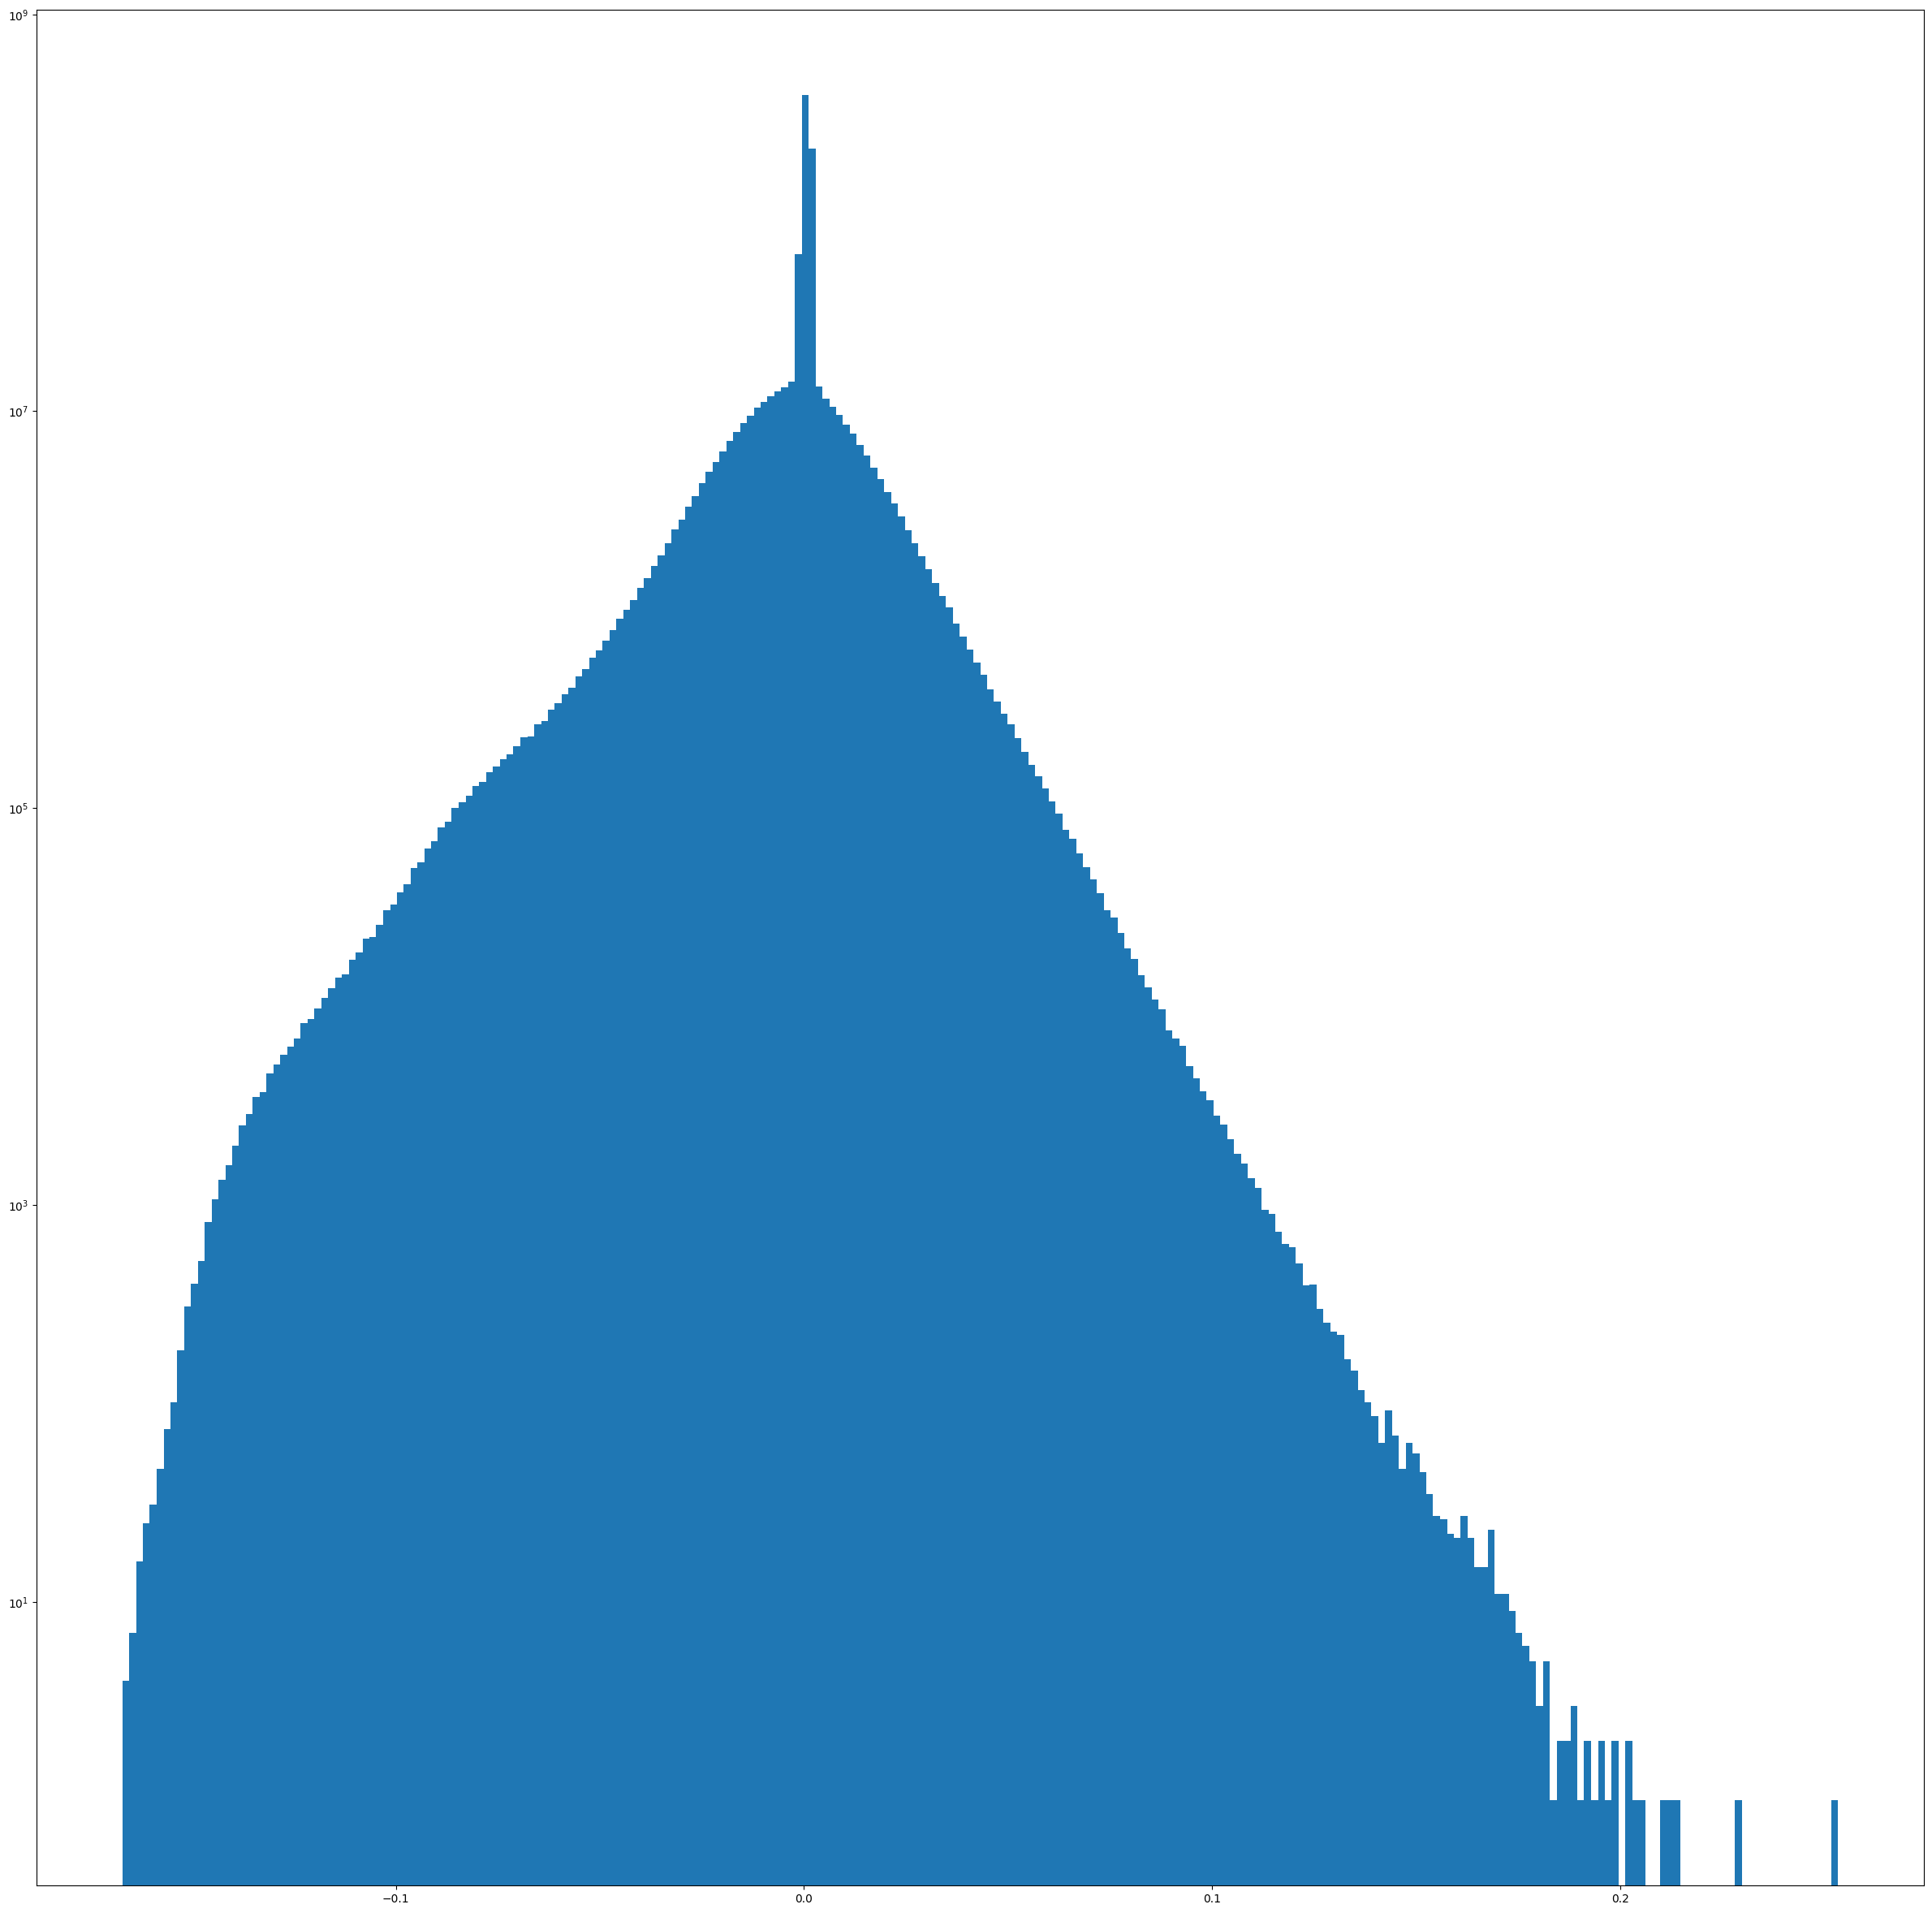

In [14]:
#hists 
plt.figure(figsize=(30,30))
plt.hist(b.flatten(), bins=250)
plt.yscale("log")

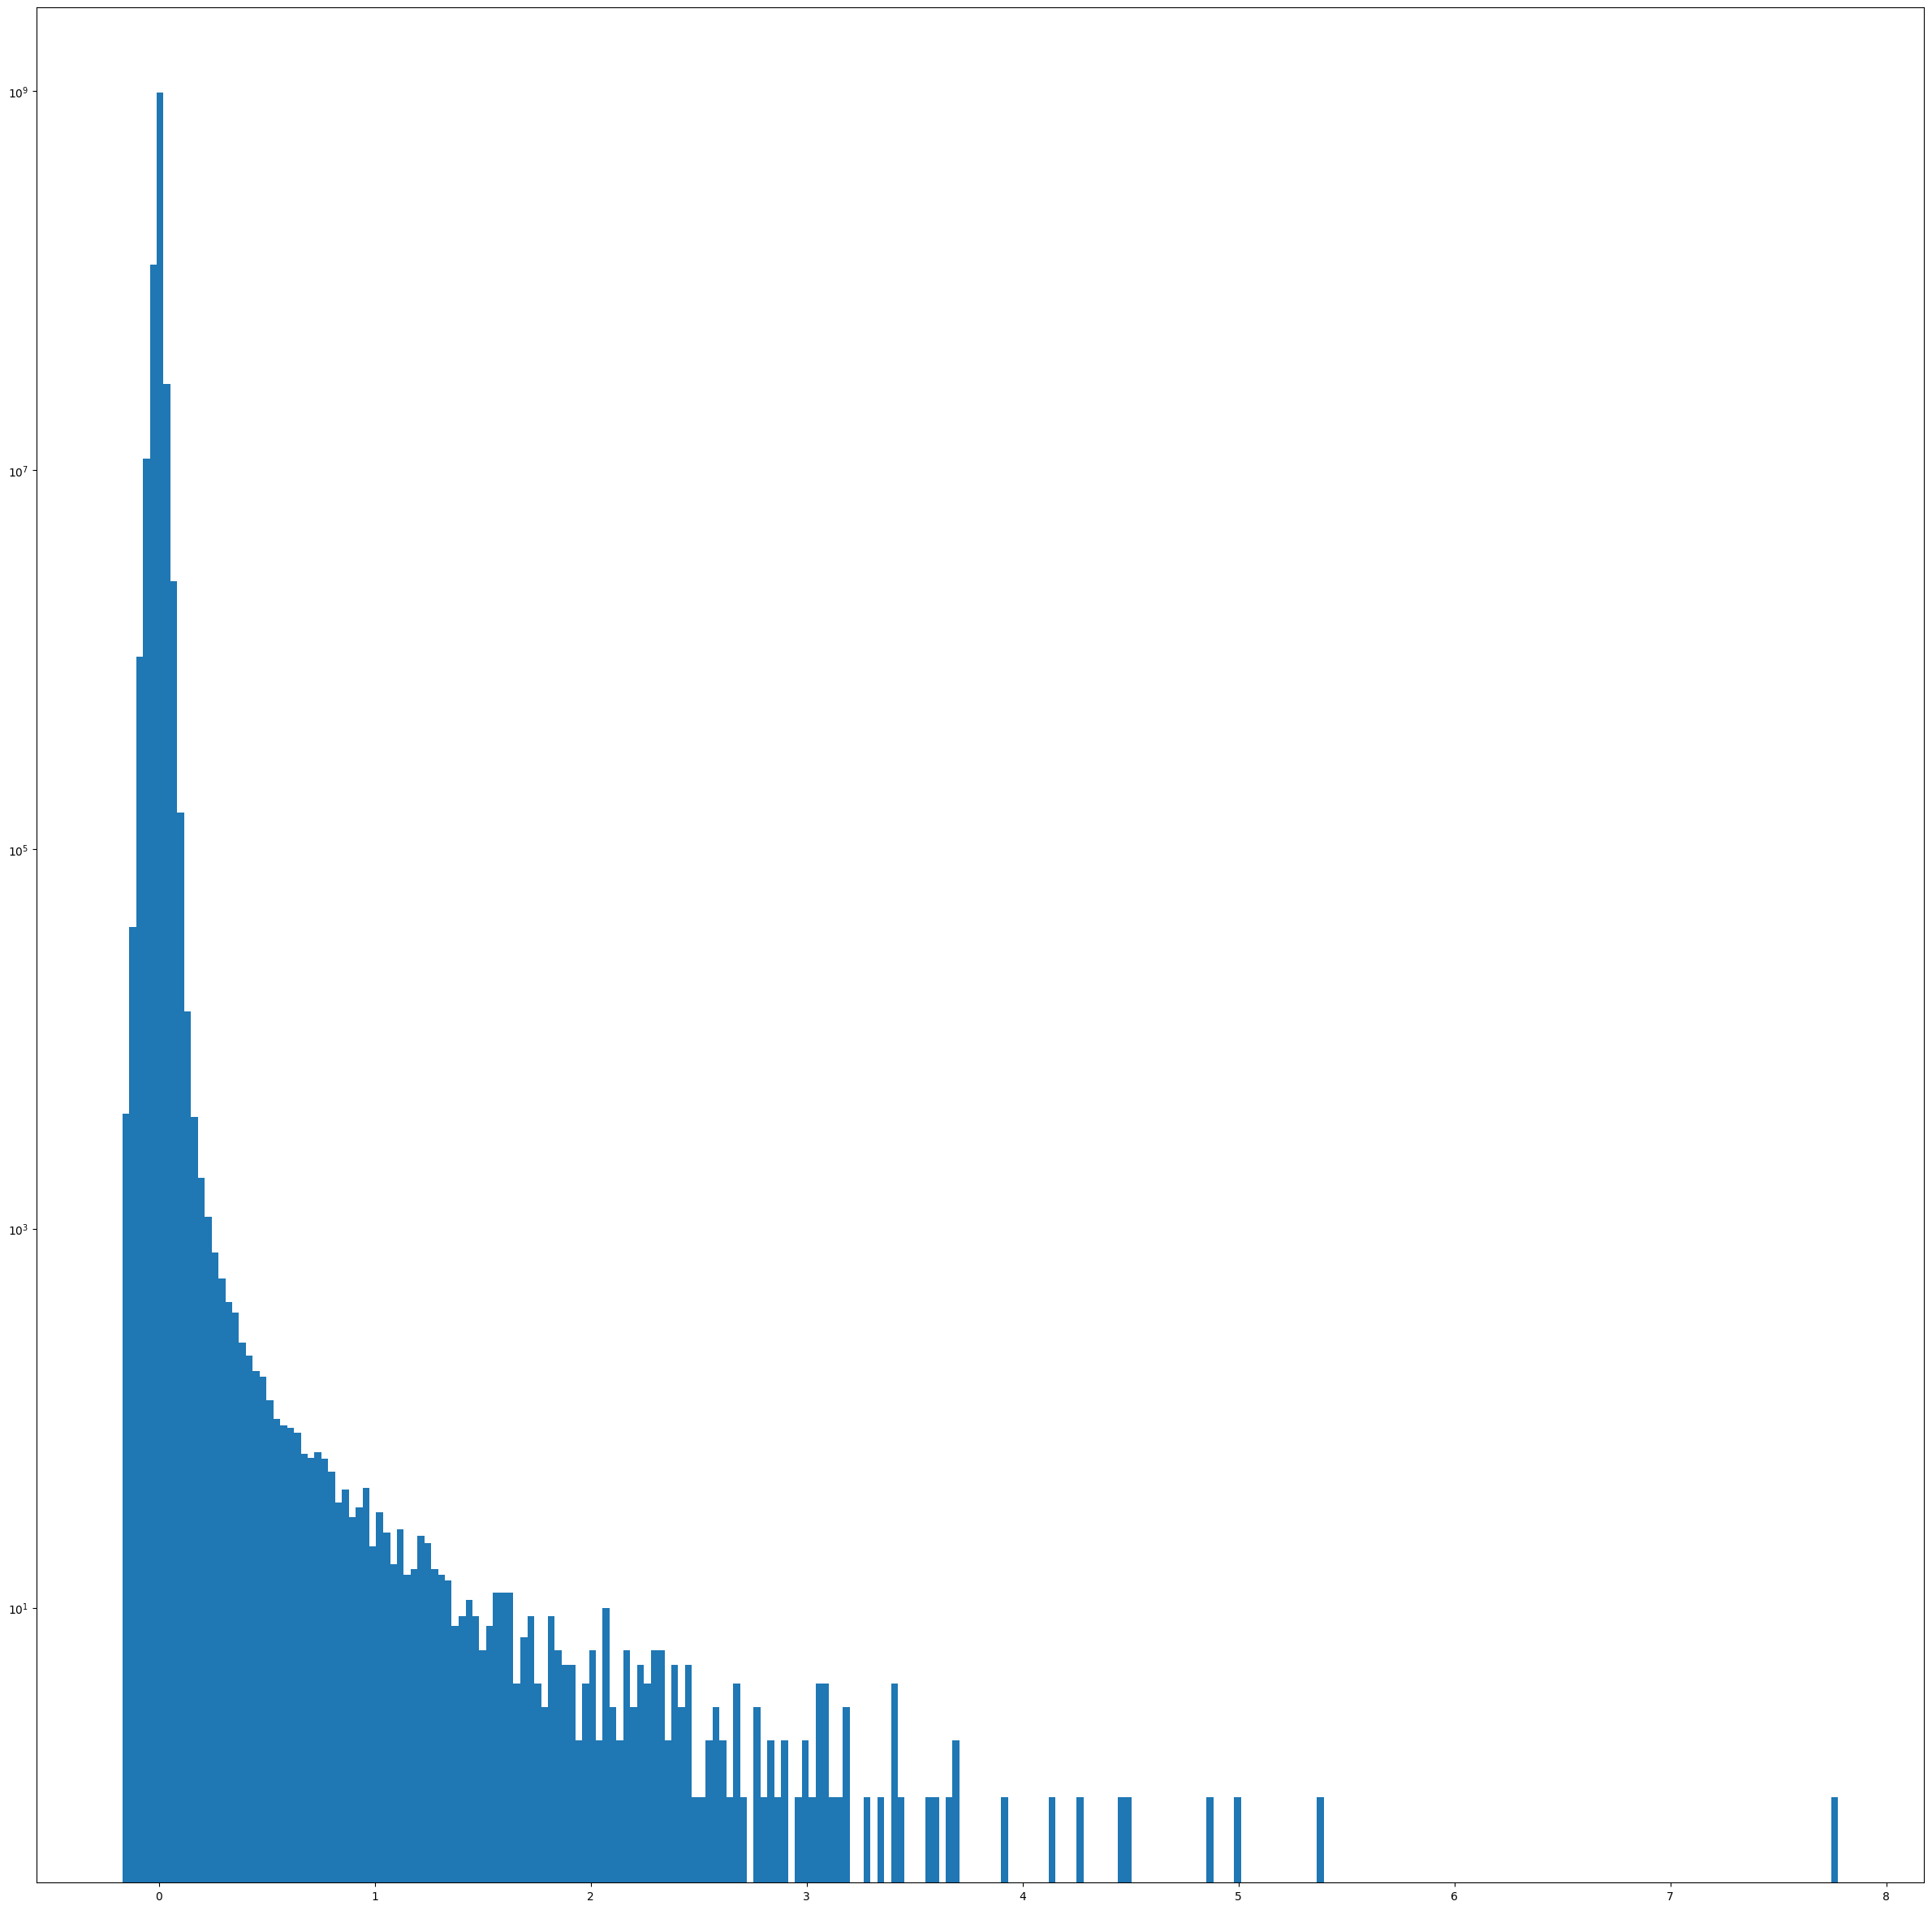

In [15]:
plt.figure(figsize=(30,30))
plt.hist(flattened.flatten(), bins=250)
plt.yscale("log")